This notebook was written in python 3; in astroconda3.6 environment.

This notebook preps the M33 data for running a probabilistic kinematic model.  
- It reads in the zspec.maskname.fits files and makes a combined table with all the spectroscopic data results.  
- It reads in the photometry files used to make the masks, and it matches the photometry to the spectroscopic data file, adding photometric columns.
- It reads in and parses Padova isochrones, for the purpose of isolating RGB stars for the kinematic analysis.
  

To do:
- It will implement CMD selection boxes based on the Padova isochrones, making selection boxes that are as consistent as possible across the 3 different filter sets (2 HST ACS, 1 CFHT/MegaCam).
- It will use these selection boxes to estimate MW contamination using Nicholas' PAndAS based contamination model.
- It will identify objects observed on more than one mask, and deal with their entries appropriately.  It will also use these duplicate mesaurements to estimate systematic uncertainties in the velocity measurements.
- It will write an astropy data table with the data necessary for running a kinematic analysis. 

In [109]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import re

from astropy.io import fits
from astropy.table import Table
from astropy.io import ascii
from astropy import units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation
from astropy import constants as const
from astropy.table import Column, vstack

%matplotlib inline

In [110]:
import pandas as pd
pd.__version__

'0.24.2'

In [111]:
# keck = EarthLocation.of_site('Keck')  # the easiest way... but requires internet
keck = EarthLocation.from_geodetic(lat=19.8283*u.deg, lon=-155.4783*u.deg, height=4160*u.m)

In [112]:
# make an M33 sky coordinate object
m33coord = SkyCoord.from_name('M33')
# and set systemic velocity of m33
m33_sys = -180. # pm 1 km/s; vanderMarel et al. 2008
m33_dmod = 24.67 # what Anil assumed

In [113]:
#filename1='2016B/zspec.M33D2A.fits'
pathspec = '/Users/kgilbert/M33/Initial_spec_data/'
filenames = [pathspec+'2016B/zspec.M33D2A.fits', pathspec+'2016B/zspec.M33D2B.fits', 
             pathspec+'2016B/zspec.M33D3A.fits', pathspec+'2016B/zspec.M33D3B.fits',
             pathspec+'2016B/zspec.M33D3D.fits',
             pathspec+'2016B/zspec.M33D4A.fits', pathspec+'2016B/zspec.M33D4B.fits',
             pathspec+'2018B/zspec.A1M33P.fits', pathspec+'2018B/zspec.B1M33P.fits']
# 2 of 10(?) from 2018B
# 7 of 10(?) from 2016B (anything from 2015B?)

In [114]:
for f in filenames:
    td = Table.read(f, hdu=1)
    #df = td.to_pandas()
    if f == filenames[0]:
        tbdata = td
        hdulist=fits.open(f)
        hdr=hdulist[1].header
        hdulist.close()
    else:
        tbdata = vstack((tbdata,td))

In [115]:
tbdata.info()

<Table length=2678>
    name      dtype  shape n_bad
------------ ------- ----- -----
       CLASS  bytes6           0
    SUBCLASS bytes17           0
     OBJNAME bytes13           0
    SLITNAME  bytes3           0
    MASKNAME  bytes6           0
        DATE bytes10           0
         MJD float64           0
           Z float32           0
       Z_ERR float32           0
       RCHI2 float32           0
         DOF   int32           0
   RCHI2DIFF float32           0
       TFILE bytes21           0
     TCOLUMN   int32 (10,)     0
  TMPL_RCHI2 float32 (35,)     0
      TMPL_Z float32 (35,)     0
  TMPL_TFILE bytes17 (35,)     0
       NPOLY   int32           0
       THETA float32 (10,)     0
       VDISP float32           0
   VDISP_ERR float32           0
    ZQUALITY   int16           0
    EIGENDIR bytes51           0
          RA bytes11           0
         DEC bytes11           0
         PRI   int16           0
        IMAG float32           0
        RMAG float32   

In [116]:
# this is supposed to print all the keys, but it doesn't work
for key, value in tbdata.meta.items():
    print('{0} = {1}'.format(key, value))

comments = ['', ' *** End of mandatory fields ***', '', '', ' *** Column names ***', '', '', ' *** Column formats ***', '', '', ' *** Column dimensions (2 D or greater) ***', '', '', ' *** End of mandatory fields ***', '', '', ' *** Column names ***', '', '', ' *** Column formats ***', '', '', ' *** Column dimensions (2 D or greater) ***', '', '', ' *** End of mandatory fields ***', '', '', ' *** Column names ***', '', '', ' *** Column formats ***', '', '', ' *** Column dimensions (2 D or greater) ***', '', '', ' *** End of mandatory fields ***', '', '', ' *** Column names ***', '', '', ' *** Column formats ***', '', '', ' *** Column dimensions (2 D or greater) ***', '', '', ' *** End of mandatory fields ***', '', '', ' *** Column names ***', '', '', ' *** Column formats ***', '', '', ' *** Column dimensions (2 D or greater) ***', '', '', ' *** End of mandatory fields ***', '', '', ' *** Column names ***', '', '', ' *** Column formats ***', '', '', ' *** Column dimensions (2 D or great

In [117]:
hdr.keys

<bound method Header.keys of XTENSION= 'BINTABLE'           /Binary table written by MWRFITS v1.11           
BITPIX  =                    8 /Required value                                  
NAXIS   =                    2 /Required value                                  
NAXIS1  =                 1284 /Number of bytes per row                         
NAXIS2  =                  294 /Number of rows                                  
PCOUNT  =                    0 /Normally 0 (no varying arrays)                  
GCOUNT  =                    1 /Required value                                  
TFIELDS =                   35 /Number of columns in table                      
COMMENT                                                                         
COMMENT  *** End of mandatory fields ***                                        
COMMENT                                                                         
COMMENT                                                                         

In [118]:
# produce heliocentric correction
sc = SkyCoord(ra=tbdata['RA'], dec=tbdata['DEC'], unit=(u.hourangle, u.deg))
barycorr = sc.radial_velocity_correction(obstime=Time(tbdata['DATE']), location=keck)  
barycorr.to(u.km/u.s)  
# radial_velocity_correction returns: The correction with a positive sign. 
# I.e., add this to an observed radial velocity 
# to get the barycentric (or heliocentric) velocity.
heliocorr = sc.radial_velocity_correction('heliocentric', obstime=Time(tbdata['DATE']), location=keck)  
heliocorr.to(u.km/u.s)  

<Quantity [ 14.04706567, 14.04529517,  5.4296382 ,...,   7.88879566,
            -8.5953029 ,  7.88385967] km / s>

In [119]:
# for testing astropy heliocentric correction against what we used in IDL consolidate.pro
print(sc[0])
print(tbdata['DATE'][0], tbdata['MJD'][0])
print(tbdata['RA'][0])

<SkyCoord (ICRS): (ra, dec) in deg
    ( 23.30604167,  30.47597222)>
2016-09-25 57656.457784
01:33:13.45


### Heliocentric and Aband Correction
The original idl lines in consolidate.pro were:

zspec[i].vraw = c*zspec[i].z

zspec[i].vhelio = (helio_deimos(ra, dec, jd=jd))[0]  

zspec[i].vcorr = zspec[i].vraw - c*zspec[i].aband - zspec[i].vhelio

Marla's helio_deimos.pro (in /kidl/mgidl/mg_deimos/helio_deimos.pro) claims this is the correction to ADD to the measured velocity to convert to heliocentric frame, 
but Raja (or Evan? or Marla?) determined/insisted it needed 
subtracted, despite that it
calls idlutils heliocentric, which also claims it will: 
"Compute correction term to add to velocities to convert to heliocentric."  

Let's make sure we get this right when switching to astropy:
A quick comparison of calling helio_deimos.pro, which defaults to the location of Keck, with RA, Dec, and JD of (MJD+2.4M) first entry in tbdata, returns 

IDL> helio_deimos(23.30604167,  30.47597222, jd=2457656.457784)

    -14.052753341442054

This is in fact the opposite sign returned by the astropy radial_velocity_correction method.

In [120]:
# make arrays of velocity, heliocentric velocity, 
# and heliocentric velocity corrected for mis-centering in the slit (aband correction)

vraw = Column(tbdata['Z']*const.c.to(u.km/u.s), name='VRAW')
verr = Column(tbdata['Z_ERR']*const.c.to(u.km/u.s), name='VERR')
vhelio = Column(vraw + heliocorr, name='VHELIO')
vcorr = Column(vraw + heliocorr - tbdata['ABAND']*const.c.to(u.km/u.s), name ='VCORR')  
# aband has been computed the same way as previously

In [121]:
# add to the data table
tbdata.add_columns([vraw, verr, vhelio, vcorr])

In [122]:
print(type(tbdata['OBJNAME'][0]))
print(type(list(tbdata['OBJNAME'])))
print(tbdata['OBJNAME'][0].find('serendip'))
print(np.core.defchararray.find(tbdata['OBJNAME'][0],'serendip'))

<class 'str'>
<class 'list'>
-1
-1


In [123]:
print(np.core.defchararray.find(list(tbdata['OBJNAME']),'serendip'))

[-1 -1  0 ..., -1  0 -1]


In [124]:
zqualityflag = 3
# having trouble adding a string comparison to the logic to create a mask

# this worked before I used hstack to combine two record arrays
#mask = (tbdata['ZQUALITY'] >= zqualityflag) & (tbdata['OBJNAME'].find('serendip') == -1)

# this worked at one point without making the astropy column object a list in second comparison statement
# but doesn't work now.  Don't know why.
mask = (tbdata['ZQUALITY'] >= zqualityflag) & (np.core.defchararray.find(list(tbdata['OBJNAME']),'serendip') == -1) \
        & (tbdata['VCORR'] < 500)
mask_alt = (tbdata['ZQUALITY'] >= zqualityflag) & (np.core.defchararray.find(list(tbdata['OBJNAME']),'serendip') == -1) \
            & (tbdata['VCORR'] < 500) & (tbdata['VCORR'] > -500)

print(len(tbdata[mask]), len(tbdata[mask_alt]))

mask1 = tbdata['ZQUALITY'] >= zqualityflag
mask2 = np.core.defchararray.find(list(tbdata['OBJNAME']),'serendip') == -1
print(len(tbdata))
print(len(tbdata[mask1]), len(tbdata[mask2]))

992 990
2678
1115 1914


Text(0, 0.5, 'Dec')

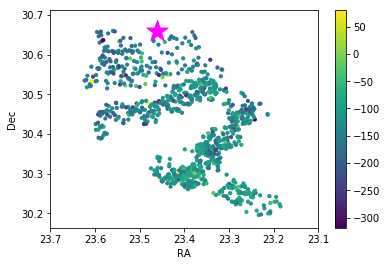

In [125]:
colorvals = tbdata['VCORR'][mask_alt]
cmap_choice = 'viridis'

vc = plt.scatter(sc[mask_alt].ra.deg, sc[mask_alt].dec.deg, c=colorvals, s=10)
plt.scatter(m33coord.ra.deg, m33coord.dec.deg, s=500, marker="*", c='fuchsia')

cbar = plt.colorbar(vc)
cbar.ax.set_ylabel('Velocity (km s$^{-1}$)')
cbar.set_alpha(1)
cbar.draw_all()

plt.xlim(23.7,23.1)
plt.xlabel('RA')
plt.ylabel('Dec')

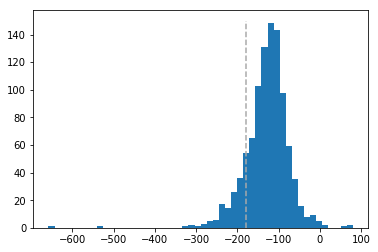

In [126]:
nbins = 50
plt.hist(tbdata['VCORR'][mask], bins=nbins)
plt.plot([m33_sys, m33_sys], [0,150], color = 'darkgrey', linestyle = '--')

Number of stars with recovered velocities from 16B masks:  771
Number of stars with recovered velocities from 16B masks, with HST photometry:  602
Number of stars with recovered velocties with CFHT photometry:  169


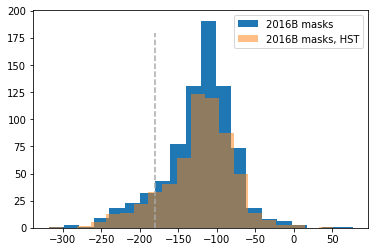

In [127]:
tbdata_good = tbdata[mask_alt]
m = (np.core.defchararray.find(list(tbdata_good['MASKNAME']),'M33D') > -1)
tbdata_good_16b = tbdata_good[m]
print('Number of stars with recovered velocities from 16B masks: ', len(tbdata_good_16b['VCORR']))

# excluding CFHT data from 2016B
m = (np.array(tbdata_good_16b['OBJNAME']).astype(int) > 5000000)

print('Number of stars with recovered velocities from 16B masks, with HST photometry: ', 
      len(tbdata_good_16b['VCORR'][m]))
print('Number of stars with recovered velocties with CFHT photometry: ', 
      len(tbdata_good_16b['VCORR']) - len(tbdata_good_16b['VCORR'][m]))
nbins = 20
plt.hist(tbdata_good_16b['VCORR'], bins=nbins, label = '2016B masks')
plt.hist(tbdata_good_16b['VCORR'][m], bins=nbins, alpha=0.5, label = '2016B masks, HST')
plt.plot([m33_sys, m33_sys], [0,180], color = 'darkgrey', linestyle = '--')
plt.legend()

Number of stars with recovered velocities from 16B masks:  219
Number of stars with recovered velocities from 18B masks, with HST photometry:  193
Number of stars with recovered velocties with CFHT photometry:  26


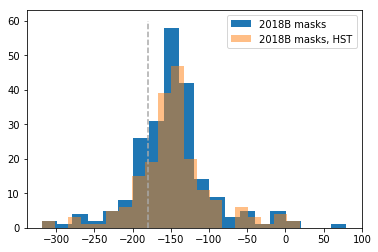

In [128]:
# 2018B masks
m = (np.core.defchararray.find(list(tbdata_good['MASKNAME']),'M33D') == -1)
tbdata_good_18b = tbdata_good[m]
print('Number of stars with recovered velocities from 16B masks: ', len(tbdata_good_18b['VCORR']))

# Excluding CFHT data from 2018B
m = (np.core.defchararray.find(list(tbdata_good_18b['OBJNAME']),'CFHT') == -1) 

print('Number of stars with recovered velocities from 18B masks, with HST photometry: ', 
      len(tbdata_good_18b['VCORR'][m]))
print('Number of stars with recovered velocties with CFHT photometry: ', 
      len(tbdata_good_18b['VCORR']) - len(tbdata_good_18b['VCORR'][m]))
nbins = 20
plt.hist(tbdata_good_18b['VCORR'], bins=nbins, label = '2018B masks')
plt.hist(tbdata_good_18b['VCORR'][m], bins=nbins, alpha=0.5, label = '2018B masks, HST')
plt.plot([m33_sys, m33_sys], [0,60], color = 'darkgrey', linestyle = '--')
plt.legend()

Number of stars from CFHT photometry in 2018B data with recovered velocities:  26


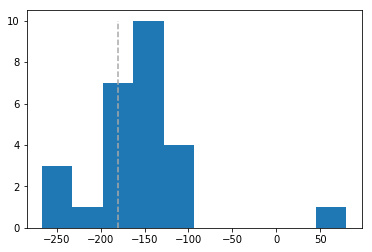

In [129]:
m = (tbdata['ZQUALITY'] >= zqualityflag) & (np.core.defchararray.find(list(tbdata['OBJNAME']),'CFHT') > -1) \
        & (tbdata['VCORR'] < 500) & (tbdata['VCORR'] > -500)

#print(tbdata['VCORR'][m])
#print(m)
print('Number of stars from CFHT photometry in 2018B data with recovered velocities: ',len(tbdata['VCORR'][m]))
nbins = 10
plt.hist(tbdata['VCORR'][m], bins=nbins)
plt.plot([m33_sys, m33_sys], [0,10], color = 'darkgrey', linestyle = '--')

In [130]:
plt.close()

## Match Spectroscopic Targets with Photometry

This is more exciting than normal due to the very mixed bag of photometry that was used between CFHT, HST, 2015B/2016B masks, and 2018B masks.  

2015B/2016B masks: CFHT/MegaCam (g', original i' filter) plus a lot of separate HST pointings, from different programs, using different filter combos. (F475W or F606W; + F814W)

2018B masks: Initial PHAT-M33 redux (combined brick 2 and 3 catalog supplied by Meredith&Dustin (which I believe comes from single field photometry) and the brick 1 half brick photometry) supplemented by the same CFHT/MegCam imaging as used in 2015B/2016B.  HST input catalog came from Anil.  See README in /Users/kgilbert/M33/Kinematic_analysis/Mask_design_photometry for more info.

Notes on the photometry files.

#### CFHT MegaCam, 2016B masks:

The gzipped M33.GI.matchcat.fits.gz file has fewer rows than the non-gzipped one. So does the extcorr file (it's number of rows matches that of M33.GI.matchcat.fits.gz.  I got 109 failed matches when using M33.GI.matchcat.fits.gz.  When I instead used M33.GI.matchcat.fits, there were no failed matches.

The magnitude and color columns in the .dsiminp files from 2015B (M33/ObservingPrep_and_Photometry/Keck_15B) match the values of mag2_auto and mag1_auto - mag2_auto in M33.GI.matchcat.fits

CFHT targets were placed in list 2 (best targets, most isolated) and list 4.

#### HST photometry, 2016B masks:

If I joined a fits file with all the HST photometry I used to make the masks, I can't find it.  Turns out you need both HST_16b_all_nolist3dups.input.fits and HST_all_list3.input.fits to have all the disk HST fields.  Despite the difference in naming convention, I believe these files both have duplicates (in overlapping HST fields) removed from list one and list 3 (the 2 HST lists used in the mask design).  

I found (what I think are) the originals of these on pakalolo in

/Users/kgilbert/M33/ObservingPrep_and_Photometry/Keck_15B/M33_HST_data/HST_all_list3.input.fits

and

/Users/kgilbert/M33/ObservingPrep_and_Photometry/Keck_16B/Observing_Prep/M33_HST_data/HST_16b_all_nolist3dups.input.fits

The magnitude column in the .dsiminp file matches the mag2_acs column in the fits file (for HST_all_list3.input.fits)

#### CFHT MegaCam, HST 2018B masks:

The fraction of targets from CFHT imaging with successful velocities is small.  Nevertheless, should include them if we can. Amanda says the object names for CFHT-photometry targets in the dsimulator files/zspec files of the 2018B masks are the *index* of the object in the CFHT photometry file she used to design the masks.  Of course, this means I need to use the same file I sent her when she was desining the masks.

I verified that the RA/Decs are spot on between 2018B/2016B_files/M33.GI.matchcat.fits.gz and the zspec RA/Decs when you assume that the zspec object name is the index of the object in this file.  It appears that _this_ is the file that was used for 2018B mask design, and not the orginal (unzipped) version of the file.

Similarly, the numeric parts of the object names in the dsimulator files/zspec files for 2018B are the *index* of the object in the HST catalog used to design the masks.  I verified that the RA/Decs are spot on between ../ObservingPrep/HST_fall18_refine.fits and the zspec RA/Decs when you assume that the zspec object name is the index of the object in this file.  This works for everything except Kristen Garafoli's xray targets ("KG[number]")

In [131]:
pathphot = '/Users/kgilbert/M33/Kinematic_analysis/Mask_design_photometry/'
photfile16b_hst = [pathphot+'HST_16b_all_nolist3dups.input.fits',  # has no objnames with values < 10000000   
                   pathphot+'HST_all_list3.input.fits']  # has objnames from 5000000 to > 9000000
#photfile16b_cfht = '/Users/kgilbert/M33/Initial_spec_data/2016B_files/M33.GI.matchcat.extcorr.fits.gz'
photfile16b_cfht = pathphot+'M33.GI.matchcat.fits' 
photfile18b_hst = pathphot+'HST_fall18_refine.fits'
photfile18b_cfht = pathphot+'M33.GI.matchcat.fits.gz' 

In [132]:
for f in photfile16b_hst:
    td = Table.read(f, hdu=1)
    #df = td.to_pandas()
    if f == photfile16b_hst[0]:
        phot16b_hst = td
        hdulist=fits.open(f)
        hdr_phot16b_hst=hdulist[1].header
        hdulist.close()
    else:
        phot16b_hst = vstack((phot16b_hst,td))

In [133]:
#phot16b_hst = Table.read(photfile16b_hst)
#hdulist=fits.open(photfile16b_hst)
#hdr_phot16b_hst=hdulist[1].header
#hdulist.close()
print(hdr_phot16b_hst.keys)

<bound method Header.keys of XTENSION= 'BINTABLE'           /Binary table written by MWRFITS v1.6a           
BITPIX  =                    8 /Required value                                  
NAXIS   =                    2 /Required value                                  
NAXIS1  =                  112 /Number of bytes per row                         
NAXIS2  =                32510 /Number of rows                                  
PCOUNT  =                    0 /Normally 0 (no varying arrays)                  
GCOUNT  =                    1 /Required value                                  
TFIELDS =                   23 /Number of columns in table                      
COMMENT                                                                         
COMMENT  *** End of mandatory fields ***                                        
COMMENT                                                                         
COMMENT                                                                         

In [134]:
print(phot16b_hst)

MASKLIST MASKPRI    OBJNAME       X       Y    ... SHARP2 CROWD2  SNR2 FLAG2
-------- -------- ------------ ------- ------- ... ------ ------ ----- -----
       1      250     14000000 3442.49 4051.65 ...  0.009  0.018 800.3     4
       1      250     14000002 2287.95 1364.86 ...  0.002  0.014 522.8     0
       1      250     14000003 2194.84 3556.08 ...  0.001  0.017 427.7     0
       1      250     14000004 2366.34 3109.87 ... -0.002  0.023 395.9     0
       1      250     14000005 1870.83  570.76 ...  0.002  0.017 384.4     0
       1      250     14000007 2667.78 2085.43 ... -0.001  0.008 371.2     0
       1      250     14000008  3633.1  4179.1 ...    0.0  0.023 366.9     0
       1      250     14000010  248.11 1243.88 ...  0.007  0.018 296.8     0
       1      250     14000011 3534.63 3655.92 ...  0.003  0.019 283.4     0
       1      250     14000012 1606.85  138.23 ... -0.001  0.014 313.3     0
     ...      ...          ...     ...     ... ...    ...    ...   ...   ...

In [135]:
print(phot16b_hst['RA'], phot16b_hst['DEC'])

      RA     
-------------
23.9001765076
23.8658556763
23.8995451752
23.8918433014
23.8561339203
23.8746714417
23.9010577026
23.8752665344
23.8936762634
23.8510412994
          ...
 23.382901651
23.3983263794
23.3911261383
23.3909087006
23.3753008667
23.3697371307
23.3851332489
23.3647208038
23.3952803436
23.3920740906
23.3904375854
Length = 60086 rows      DEC     
-------------
30.4940128326
30.4661865234
30.4753780365
30.4754981995
30.4569683075
 30.474565506
30.4971065521
30.4389915466
30.4933376312
30.4514694214
          ...
30.3106627953
  30.25938182
30.2883525384
30.2914729607
30.3063369286
30.2996593011
30.3066154015
30.3086371911
30.3182731164
30.2845340264
30.2958350671
Length = 60086 rows


In [136]:
phot16b_cfht = Table.read(photfile16b_cfht)
hdulist=fits.open(photfile16b_cfht)
hdr_phot16b_cfht=hdulist[1].header
hdulist.close()
print(hdr_phot16b_cfht.keys)

<bound method Header.keys of XTENSION= 'BINTABLE'           /Binary table written by MWRFITS v1.6a           
BITPIX  =                    8 /Required value                                  
NAXIS   =                    2 /Required value                                  
NAXIS1  =                  232 /Number of bytes per row                         
NAXIS2  =               502166 /Number of rows                                  
PCOUNT  =                    0 /Normally 0 (no varying arrays)                  
GCOUNT  =                    1 /Required value                                  
TFIELDS =                   30 /Number of columns in table                      
COMMENT                                                                         
COMMENT  *** End of mandatory fields ***                                        
COMMENT                                                                         
COMMENT                                                                         

In [137]:
print(phot16b_cfht['RA1'], phot16b_cfht['DEC1'])

   RA1    
----------
23.3923351
 23.346682
23.3486371
23.3408122
23.3826236
23.3775972
 23.379145
23.3193851
23.3754644
23.3910679
       ...
23.6709677
23.6026143
23.4850967
23.4565947
23.6031832
23.5578119
23.7694239
23.6826889
23.7683064
23.4333954
23.5396627
Length = 502166 rows    DEC1   
----------
30.1485663
30.1486549
30.1486513
30.1487527
30.1487346
30.1487314
30.1487801
30.1487983
30.1488471
 30.148867
       ...
31.1811397
31.1808604
31.1814164
31.1817068
31.1804669
31.1822682
31.1802686
31.1813876
31.1804528
 31.180985
31.1774331
Length = 502166 rows


In [138]:
phot18b_cfht = Table.read(photfile18b_cfht)
hdulist=fits.open(photfile18b_cfht)
hdr_phot18b_cfht=hdulist[1].header
hdulist.close()
print(hdr_phot18b_cfht.keys)

<bound method Header.keys of XTENSION= 'BINTABLE'           /Binary table written by MWRFITS v1.6a           
BITPIX  =                    8 /Required value                                  
NAXIS   =                    2 /Required value                                  
NAXIS1  =                  232 /Number of bytes per row                         
NAXIS2  =               430337 /Number of rows                                  
PCOUNT  =                    0 /Normally 0 (no varying arrays)                  
GCOUNT  =                    1 /Required value                                  
TFIELDS =                   30 /Number of columns in table                      
COMMENT                                                                         
COMMENT  *** End of mandatory fields ***                                        
COMMENT                                                                         
COMMENT                                                                         

In [139]:
phot18b_hst = Table.read(photfile18b_hst)
hdulist=fits.open(photfile18b_hst)
hdr_phot18b_hst=hdulist[1].header
hdulist.close()
print(hdr_phot18b_hst.keys)

<bound method Header.keys of XTENSION= 'BINTABLE'           /Binary table written by MWRFITS v1.4a           
BITPIX  =                    8 /Required value                                  
NAXIS   =                    2 /Required value                                  
NAXIS1  =                   63 /Number of bytes per row                         
NAXIS2  =               448149 /Number of rows                                  
PCOUNT  =                    0 /Normally 0 (no varying arrays)                  
GCOUNT  =                    1 /Required value                                  
TFIELDS =                   12 /Number of columns in table                      
COMMENT                                                                         
COMMENT  *** End of mandatory fields ***                                        
COMMENT                                                                         
COMMENT                                                                         

In [140]:
print(phot18b_hst['RA'], phot18b_hst['DEC'])

      RA     
-------------
23.5898768301
23.5366081381
23.5588775516
23.6305060463
23.5388244205
 23.640254148
23.5492206861
23.5406411035
23.5493804822
23.6498149937
          ...
23.3561971468
23.3726800968
23.3814563468
23.3549483168
23.3708541968
23.3648050968
23.3550780268
23.3809075568
23.3775794368
23.3709436868
23.3724860768
Length = 448149 rows      DEC     
-------------
30.7233834462
30.7769395099
30.7838522474
 30.769108158
30.7574267396
30.7818885797
30.7752763128
30.7786712069
30.7751084116
30.7580514571
          ...
 30.558838967
 30.556299177
 30.526378797
 30.559091397
 30.556607617
 30.557546167
 30.559002327
 30.523816197
 30.555507407
 30.556522407
 30.556402187
Length = 448149 rows


Text(0.5, 1.0, '2018B HST Catalog')

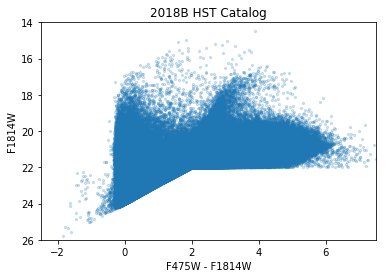

In [141]:
plt.scatter(phot18b_hst['F475W_VEGA']-phot18b_hst['F814W_VEGA'], phot18b_hst['F814W_VEGA'], s=5, alpha=0.2)
plt.xlim(-2.5,7.5)
plt.ylim(26,14)
plt.xlabel('F475W - F1814W')
plt.ylabel('F1814W')
plt.title('2018B HST Catalog')

Text(0.5, 1.0, '2016B HST Catalogs')

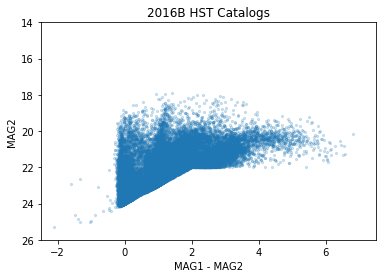

In [142]:
# MAG1 is not always the same filter! (mostly F606W, but some F475W...)
plt.scatter(phot16b_hst['MAG1_ACS']-phot16b_hst['MAG2_ACS'], phot16b_hst['MAG2_ACS'], s=5, alpha=0.2)
plt.xlim(-2.5,7.5)
plt.ylim(26,14)
plt.xlabel('MAG1 - MAG2')
plt.ylabel('MAG2')
plt.title('2016B HST Catalogs')

Text(0.5, 1.0, '2016B CFHT Catalog')

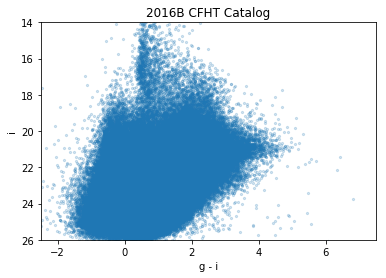

In [143]:
plt.scatter(phot16b_cfht['MAG1_AUTO']-phot16b_cfht['MAG2_AUTO'], phot16b_cfht['MAG2_AUTO'], s=5, alpha=0.2)
plt.xlim(-2.5,7.5)
plt.ylim(26,14)
plt.xlabel('g - i')
plt.ylabel('i')
plt.title('2016B CFHT Catalog')

In [144]:
plt.close()

Going to have to clean up input photometry files considerably (including calculating extinction-corrected mags).  Need to track the filters.

For now, let's just match what we have.


In [145]:
# Set up new photometry columns for the data table
# AUTO is kron-like elliptical aperture magnitude -- use this one
# 'BEST' is Best of MAG_AUTO and MAG_ISOCOR - in other words, don't know which one
mag1_cfht = Column(np.ones(len(tbdata))*np.nan, name='G_AUTO_CFHT')
mag1err_cfht = Column(np.ones(len(tbdata))*np.nan, name='G_AUTO_CFHT_ERR')
# all masks on central pointing from 'M33', which is original 'i' CFHT MegaCam filter
# if/when get minor axis masks, those, *if made from 'M3305' pointing*, were observed with 'i2' filter
mag2_cfht = Column(np.ones(len(tbdata))*np.nan, name='I_AUTO_CFHT') 
mag2err_cfht = Column(np.ones(len(tbdata))*np.nan, name='I_AUTO_CFHT_ERR') 

mag1a_hst16b = Column(np.ones(len(tbdata))*np.nan, name='F475W_ACS')
mag1aerr_hst16b = Column(np.ones(len(tbdata))*np.nan, name='F475W_ACS_ERR')
mag1b_hst16b = Column(np.ones(len(tbdata))*np.nan, name='F606W_ACS')
mag1berr_hst16b = Column(np.ones(len(tbdata))*np.nan, name='F606W_ACS_ERR')
mag2_hst16b = Column(np.ones(len(tbdata))*np.nan, name='F814W_ACS')
mag2err_hst16b = Column(np.ones(len(tbdata))*np.nan, name='F814W_ACS_ERR')

# current photometry file doesn't have error
mag1_hst18b = Column(np.ones(len(tbdata))*np.nan, name='F475W_VEGA')
mag2_hst18b = Column(np.ones(len(tbdata))*np.nan, name='F814W_VEGA')
feh = Column(np.ones(len(tbdata))*np.nan, name='FEH')
# targtype = Column(['']*len(tbdata), dtype=np.object, name='TARGTYPE') # this causes issues 
# with writing the file to fits - can't write an np.object into a fits file
targtype = Column(['']*len(tbdata), dtype=np.dtype('U20'), name='TARGTYPE')

In [146]:
print(phot18b_hst['FEH'], phot18b_hst['TARGTYPE'])

   FEH   
---------
      0.0
      0.0
      0.0
      0.0
      0.0
      0.0
      0.0
      0.0
      0.0
      0.0
      ...
-0.860471
-0.617922
-0.693557
   -0.695
-0.688001
      0.0
      0.0
      0.0
      0.0
      0.0
      0.0
Length = 448149 rows   TARGTYPE 
-----------
AGB        
RHeB_bright
RHeB_bright
AGB        
RHeB_bright
AGB        
RHeB_bright
RHeB_bright
AGB        
RHeB_bright
        ...
RGB        
RGB        
RGB        
RGB        
RGB        
AGB        
MS         
MS         
MS         
MS         
MS         
Length = 448149 rows


In [147]:
tbdata.add_columns([mag1_cfht, mag1err_cfht, mag2_cfht, mag2err_cfht, mag1a_hst16b, mag1aerr_hst16b, 
                    mag1b_hst16b, mag1berr_hst16b, mag2_hst16b, mag2err_hst16b, 
                    mag1_hst18b, mag2_hst18b, feh, targtype])

In [148]:
print(tbdata['OBJNAME'][100].strip(), tbdata['MASKNAME'][100])
#print(type(phot16b_hst['OBJNAME']))
#print(type(np.array(phot16b_cfht['OBJNO1'])))
#print(type(phot16b_cfht['OBJNO1'][0]))
#print(np.array(phot16b_hst['OBJNAME']).astype(int))
#print(type(int(tbdata['OBJNAME'][1])))

item_index = np.where(np.array(phot16b_hst['OBJNAME']).astype(int) == int(tbdata['OBJNAME'][100]))
print(item_index)
item_index = np.flatnonzero(np.array(phot16b_hst['OBJNAME']).astype(int) == int(tbdata['OBJNAME'][100]))
print(item_index)
print(phot16b_hst['OBJNAME'][item_index], tbdata['OBJNAME'][100])
#tbdata['F814W_ACS'][100] = phot16b_hst['MAG2_ACS'][item_index]
print(tbdata['F814W_ACS'][100])

print(tbdata['OBJNAME'][5].strip(), tbdata['MASKNAME'][5])
item_index = np.where(np.array(phot16b_cfht['OBJNO1']) == int(tbdata['OBJNAME'][5]))
print(item_index)
print(len(item_index))
item_index = np.flatnonzero(np.array(phot16b_cfht['OBJNO1']) == int(tbdata['OBJNAME'][5]))
print(item_index)

item_index = []
print(len(item_index))
if item_index:
    print('has value')
else:
    print('nope')

11003449 M33D2A
(array([3404]),)
[3404]
  OBJNAME   
------------
    11003449 11003449 
nan
181971 M33D2A
(array([118830]),)
1
[118830]
0
nope


In [150]:
# Use objname ranges (set by me when making masks) and appropriate logic to fill out photometry entries

failed_matches = []
too_many_matches = []
successful_matches = []
failed_logic_matches = []
count = 0

sc_tbdata = SkyCoord(ra=tbdata['RA'], dec=tbdata['DEC'], unit=(u.hourangle, u.deg))
sc_phot16b_hst = SkyCoord(ra=phot16b_hst['RA'], dec=phot16b_hst['DEC'], unit=(u.deg, u.deg))
sc_phot16b_cfht = SkyCoord(ra=phot16b_cfht['RA1'], dec=phot16b_cfht['DEC1'], unit=(u.deg, u.deg))
sc_phot18b_hst = SkyCoord(ra=phot18b_hst['RA'], dec=phot18b_hst['DEC'], unit=(u.deg, u.deg))
sc_phot18b_cfht = SkyCoord(ra=phot18b_cfht['RA1'], dec=phot18b_cfht['DEC1'], unit=(u.deg, u.deg))

sc_distance = []
sc_distance_cfht = []
sc_distance_cfht18b = []
sc_distance_hst16b = []
sc_distance_hst18b = []


for i in np.arange(len(tbdata)):
    #print()
    if (np.core.defchararray.find(tbdata['MASKNAME'][i],'M33D') > -1) \
        and (np.core.defchararray.find(tbdata['OBJNAME'][i],'serendip') == -1): #a 2016B target
        count += 1
        if (int(tbdata['OBJNAME'][i]) >= 5000000 and int(tbdata['OBJNAME'][i]) < 8000000) or \
            (int(tbdata['OBJNAME'][i]) >= 11000000): # `Blue' filter is F606W HST 
            
            item_index = np.flatnonzero(np.array(phot16b_hst['OBJNAME']).astype(int) == int(tbdata['OBJNAME'][i]))
            #print(item_index)
            #print('2016B F606W HST')
            
            if len(item_index) == 1:
                #print(phot16b_hst['OBJNAME'][item_index], tbdata['OBJNAME'][i])
                #print(sc_phot16b_hst[item_index])
                #print(sc_tbdata[i])
                if sc_phot16b_hst[item_index].separation(sc_tbdata[i]).arcsecond > 0.2:
                    print('2016B F606W HST: ', sc_phot16b_hst[item_index].separation(sc_tbdata[i]))
                
                tbdata['F606W_ACS'][i] = phot16b_hst['MAG1_ACS'][item_index]
                tbdata['F606W_ACS_ERR'][i] = phot16b_hst['MAG1_ERR'][item_index]
                tbdata['F814W_ACS'][i] = phot16b_hst['MAG2_ACS'][item_index]
                tbdata['F814W_ACS_ERR'][i] = phot16b_hst['MAG2_ERR'][item_index]
                successful_matches.append(i)
                sc_distance.append(sc_phot16b_hst[item_index].separation(sc_tbdata[i]))
                sc_distance_hst16b.append(sc_phot16b_hst[item_index].separation(sc_tbdata[i]))
                
            elif len(item_index) > 1:
                print('More than one entry found for: ', tbdata['OBJNAME'][i], tbdata['MASKNAME'][i])
                print(phot16b_hst['OBJNAME'][item_index])
                too_many_matches.append(i)
            else:
                print('STAR NOT FOUND: ', tbdata['OBJNAME'][i], tbdata['MASKNAME'][i])
                failed_matches.append(i)

        if (int(tbdata['OBJNAME'][i]) >= 8000000 and int(tbdata['OBJNAME'][i]) < 11000000): # `Blue' filter is F475W HST 
            item_index = np.flatnonzero(np.array(phot16b_hst['OBJNAME']).astype(int) == int(tbdata['OBJNAME'][i]))
            #print(item_index)
            #print('2016B F475W HST')
            if len(item_index) == 1:
                #print(phot16b_hst['OBJNAME'][item_index], tbdata['OBJNAME'][i])
                #print(sc_phot16b_hst[item_index])
                #print(sc_tbdata[i])
                if sc_phot16b_hst[item_index].separation(sc_tbdata[i]).arcsecond > 0.2:
                    print('2016B F475W HST: ', sc_phot16b_hst[item_index].separation(sc_tbdata[i]))
                tbdata['F475W_ACS'][i] = phot16b_hst['MAG1_ACS'][item_index]
                tbdata['F475W_ACS_ERR'][i] = phot16b_hst['MAG1_ERR'][item_index]
                tbdata['F814W_ACS'][i] = phot16b_hst['MAG2_ACS'][item_index]
                tbdata['F814W_ACS_ERR'][i] = phot16b_hst['MAG2_ERR'][item_index]
                successful_matches.append(i)
                sc_distance.append(sc_phot16b_hst[item_index].separation(sc_tbdata[i]))
                sc_distance_hst16b.append(sc_phot16b_hst[item_index].separation(sc_tbdata[i]))
                
            elif len(item_index) > 1:
                print('More than one entry found for: ', tbdata['OBJNAME'][i], tbdata['MASKNAME'][i])
                print(phot16b_hst['OBJNAME'][item_index])
                too_many_matches.append(i)
            else:
                print('STAR NOT FOUND: ', tbdata['OBJNAME'][i], tbdata['MASKNAME'][i])
                failed_matches.append(i)
                
        if (int(tbdata['OBJNAME'][i]) < 5000000): #CFHT
            #print('2016B CFHT')
            item_index = np.flatnonzero(np.array(phot16b_cfht['OBJNO1']) == int(tbdata['OBJNAME'][i].strip()))
            #print(item_index)
            if len(item_index) == 1:
                #print(phot16b_cfht['OBJNO1'][item_index], tbdata['OBJNAME'][i])
                #print(sc_phot16b_cfht[item_index])
                #print(sc_tbdata[i])
                if sc_phot16b_cfht[item_index].separation(sc_tbdata[i]).arcsecond  > 0.3:
                    print('2016B CFHT: ',sc_phot16b_cfht[item_index].separation(sc_tbdata[i]))
                if sc_phot16b_cfht[item_index].separation(sc_tbdata[i]).arcsecond  < 0.5:
                    tbdata['G_AUTO_CFHT'][i] = phot16b_cfht['MAG1_AUTO'][item_index]
                    tbdata['I_AUTO_CFHT'][i] = phot16b_cfht['MAG2_AUTO'][item_index]
                    tbdata['G_AUTO_CFHT_ERR'][i] = phot16b_cfht['MAG1ERR_AUTO'][item_index]
                    tbdata['I_AUTO_CFHT_ERR'][i] = phot16b_cfht['MAG2ERR_AUTO'][item_index]
                    successful_matches.append(i)
                    sc_distance.append(sc_phot16b_cfht[item_index].separation(sc_tbdata[i]))
                    sc_distance_cfht.append(sc_phot16b_cfht[item_index].separation(sc_tbdata[i]))
                else:
                    print('Separation more than 0.5 arcseconds for 2016 CFHT target ',
                          tbdata['OBJNAME'][i] ,'; considered a failed match')
                    failed_matches.append(i)
            elif len(item_index) > 1:
                print('More than one entry found for: ', tbdata['OBJNAME'][i], tbdata['MASKNAME'][i])
                print(phot16b_cfht['OBJNO1'][item_index])
                too_many_matches.append(i)
            else:
                print('STAR NOT FOUND: ', tbdata['OBJNAME'][i], tbdata['MASKNAME'][i])
                failed_matches.append(i)
                
    elif np.core.defchararray.find(tbdata['MASKNAME'][i],'M33P') > -1 \
        and (np.core.defchararray.find(tbdata['OBJNAME'][i],'serendip') == -1): # a 2018B mask
        
        # For 2018, the photometry file doesn't include objnames.  may have to match by RA and Dec.
        # Amanda says the numeric portion of the object names (dsimulator/zspec) are the *index* of the object 
            # in the CFHT and HST photometry files used in the 2018 mask design
            # of course, this means you need the correct files to use the object name as an index...
        
        if np.core.defchararray.find(tbdata['OBJNAME'][i],'CFHT') > -1: 
            # from CFHT catalog, only 26 objects with zquality > 3
            
            #print('2018B CFHT: ', tbdata['OBJNAME'][i], tbdata['OBJNAME'][i].replace('CFHT','').strip())
            item_index = [int(tbdata['OBJNAME'][i].replace('CFHT','').strip())]
            # make item_index an array like above, since want to use
            # ravel later, and for it to work properly will need to be consistent with above
            
            #print(item_index)
            #print(sc_phot18b_cfht[item_index])
            #print(sc_tbdata[i])
            #print(phot18b_cfht['MAG1_AUTO'][item_index], phot18b_cfht['MAG2_AUTO'][item_index])
            if sc_phot18b_cfht[item_index].separation(sc_tbdata[i]).arcsecond  > 0.3:
                print('2018B CFHT: ',sc_phot18b_cfht[item_index].separation(sc_tbdata[i]))
            if sc_phot18b_cfht[item_index].separation(sc_tbdata[i]).arcsecond  < 0.5: # set threshold decently high for CFHT
                tbdata['G_AUTO_CFHT'][i] = phot18b_cfht['MAG1_AUTO'][item_index]
                tbdata['I_AUTO_CFHT'][i] = phot18b_cfht['MAG2_AUTO'][item_index]
                tbdata['G_AUTO_CFHT_ERR'][i] = phot18b_cfht['MAG1ERR_AUTO'][item_index]
                tbdata['I_AUTO_CFHT_ERR'][i] = phot18b_cfht['MAG2ERR_AUTO'][item_index]
                successful_matches.append(i)
                sc_distance.append(sc_phot18b_cfht[item_index].separation(sc_tbdata[i]))
                sc_distance_cfht18b.append(sc_phot18b_cfht[item_index].separation(sc_tbdata[i]))
            else:
                print('Separation more than 0.5 arcseconds for 2018 CFHT target ',
                      tbdata['OBJNAME'][i] ,'; considered a failed match')
                failed_matches.append(i)
        else:
            #print('2018B HST')
            item_index = [int(re.sub(r"\D", "", tbdata['OBJNAME'][i]))]
            if sc_phot18b_hst[item_index].separation(sc_tbdata[i]).arcsecond  > 0.2: # threshold lower for HST
                print('2018B HST target ',tbdata['OBJNAME'][i],' separation: ',sc_phot18b_hst[item_index].separation(sc_tbdata[i]))
                print('Separation more than 0.2 arcseconds for HST target ',
                      tbdata['OBJNAME'][i] ,'; considered a failed match')
                failed_matches.append(i)
            else:
                tbdata['F475W_VEGA'][i] = phot18b_hst['F475W_VEGA'][item_index]
                tbdata['F814W_VEGA'][i] = phot18b_hst['F814W_VEGA'][item_index]
                tbdata['FEH'][i] = phot18b_hst['FEH'][item_index]
                tbdata['TARGTYPE'][i] = phot18b_hst['TARGTYPE'][item_index[0]]
                #print(phot18b_hst['TARGTYPE'][item_index[0]], tbdata['TARGTYPE'][i])
                successful_matches.append(i)
                sc_distance.append(sc_phot18b_hst[item_index].separation(sc_tbdata[i]))
                sc_distance_hst18b.append(sc_phot18b_hst[item_index].separation(sc_tbdata[i]))

    else:
        #print('Didn\'t end up in logic loop for target ', tbdata['MASKNAME'][i], tbdata['OBJNAME'][i])
        failed_logic_matches.append(i)

2016B CFHT:  [0d00m00.342s]
2016B CFHT:  [0d00m00.3145s]
2016B CFHT:  [0d00m00.3098s]
2016B CFHT:  [0d00m00.3338s]
2016B CFHT:  [0d00m00.3573s]
2016B CFHT:  [0d00m00.3445s]
2016B CFHT:  [0d00m00.3003s]
2016B CFHT:  [0d00m00.3033s]
2016B CFHT:  [0d00m00.3004s]
2016B CFHT:  [0d00m00.3115s]
2016B CFHT:  [0d00m00.3054s]
2016B CFHT:  [0d00m00.357s]
2016B CFHT:  [0d00m00.3053s]
2018B HST target  KG347          separation:  [0d12m19.4083s]
Separation more than 0.2 arcseconds for HST target  KG347         ; considered a failed match
2018B HST target  KG316          separation:  [0d09m53.7053s]
Separation more than 0.2 arcseconds for HST target  KG316         ; considered a failed match
2018B HST target  KG272          separation:  [0d15m55.0393s]
Separation more than 0.2 arcseconds for HST target  KG272         ; considered a failed match
2018B HST target  KG337          separation:  [0d13m24.272s]
Separation more than 0.2 arcseconds for HST target  KG337         ; considered a failed match


Text(0.5, 0, 'Distance between Phot and Spec Coords (arcsec)')

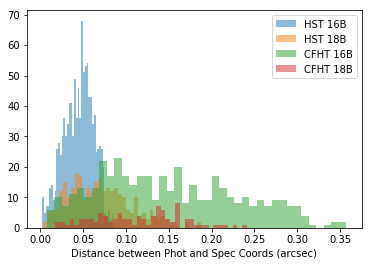

In [152]:
# Check the matches
# HST catalogs from 2016B and 2018B have 10 significant digits after decimal on RA, Dec
# CFHT catalog has 7.

nbins = 40
#plt.hist(np.ravel([d.arcsec for d in sc_distance]), bins=nbins, label='All')
plt.hist(np.ravel([d.arcsec for d in sc_distance_hst16b]), bins=nbins, alpha=0.5, label='HST 16B')
plt.hist(np.ravel([d.arcsec for d in sc_distance_hst18b]), bins=nbins, alpha=0.5, label='HST 18B')
plt.hist(np.ravel([d.arcsec for d in sc_distance_cfht]), bins=nbins, alpha=0.5, label = 'CFHT 16B')
plt.hist(np.ravel([d.arcsec for d in sc_distance_cfht18b]), bins=nbins, alpha=0.5, label = 'CFHT 18B')
plt.legend()
plt.xlabel('Distance between Phot and Spec Coords (arcsec)')

In [153]:
print(len(failed_matches))
#print(failed_matches)
print(len(too_many_matches))
print(len(tbdata))
print(count)

4
0
2678
1512


In [154]:
print(tbdata['OBJNAME'][failed_matches])
print(tbdata['OBJNAME'][too_many_matches])

   OBJNAME   
-------------
KG347        
KG316        
KG272        
KG337        
OBJNAME
-------


In [ ]:
# debug statements, 2016B
#m = (np.array(tbdata['OBJNAME'][failed_matches]).astype(int) < 5000000)
#print(tbdata['OBJNAME'][failed_matches][m])
#m = (np.array(tbdata['OBJNAME'][too_many_matches]).astype(int) < 5000000)
#print(tbdata['OBJNAME'][too_many_matches][m])

In [ ]:
# debug statements, 2016B
#m = (np.array(tbdata['OBJNAME'][failed_matches]).astype(int) >= 5000000)
#print(tbdata['OBJNAME'][failed_matches][m])
#m = (np.array(tbdata['OBJNAME'][too_many_matches]).astype(int) >= 5000000)
#print(tbdata['OBJNAME'][too_many_matches][m])

In [ ]:
# spot check photometry against Amanda's all_target_list.in
#for t in tbdata[m3]:
#    print(t['OBJNAME'], t['F475W_VEGA'], t['F814W_VEGA'])

In [155]:
# to compare 2018 CFHT photometry to that in all_target_list.in.  
m = ((tbdata['ZQUALITY'] >= zqualityflag) & (~np.isnan(tbdata['G_AUTO_CFHT'])))
for t in tbdata[m]:
    print(t['OBJNAME'], t['RA'], t['DEC'], t['G_AUTO_CFHT'], t['I_AUTO_CFHT'])

181325    01:34:20.36 +30:23:22.7 23.5179 21.9958
181971    01:34:22.06 +30:23:26.3 22.9108 20.5428
190652    01:34:17.58 +30:24:1.9  22.6974 20.5969
198740    01:34:23.46 +30:24:38.3 23.8876 21.8149
206727    01:34:21.43 +30:25:8.4  22.119 21.7811
209140    01:34:20.00 +30:25:15.9 21.6399 19.567
211223    01:34:23.63 +30:25:30.3 24.1673 21.2137
212176    01:33:57.68 +30:25:33.3 23.231 21.5909
215883    01:33:56.31 +30:25:41.2 20.4285 20.6461
220006    01:33:51.24 +30:26:4.9  23.4176 21.8152
226705    01:33:58.87 +30:26:26.3 22.9023 21.1516
227559    01:33:52.68 +30:26:33.5 23.5443 21.6696
228190    01:33:57.39 +30:26:31.0 21.3284 20.2857
229225    01:33:55.72 +30:26:39.5 22.9975 20.9252
229794    01:33:53.24 +30:26:41.9 23.3415 21.7492
230448    01:33:57.45 +30:26:44.3 23.9449 21.2398
237330    01:33:52.18 +30:27:12.0 24.0463 20.2581
238675    01:33:54.88 +30:27:17.1 23.4225 21.8656
239037    01:33:52.63 +30:27:16.6 22.5356 21.2831
241675    01:33:59.86 +30:27:24.2 21.448 20.3701
2457

### Compute Star by Star Extinction Corrections

In [156]:
# Let's implement the SFD, so the values from Table 6 of SF11
# Note that they are pretty different than what was assumed in IDL procedure for Sloan g' and i'
acs_475 = 3.268
acs_606 = 2.471
acs_814 = 1.526
sdss_g = 3.303
sdss_i = 1.698

In [157]:
import sfdmap
# https://github.com/kbarbary/sfdmap

# Create a SFD map object to query
emap = sfdmap.SFDMap('/Users/kgilbert/astroconda_package_data/sfdmap/sfddata-master/', scaling=1.0) 
# By default this applies a a scaling of 0.86 is applied to the map values to reflect the 
# recalibration by Schlafly & Finkbeiner (2011). 
# To get the original SFD values, use scaling=1.0 when constructing the map

## The band extinction factors above are to be applied to SFD values to obtain 
# the recalibrated SandF bandpass extinction.  Confusing.

In [158]:
extinct_map = emap.ebv(sc_tbdata)
print(extinct_map)

[ 0.04491931  0.04495219  0.06319197 ...,  0.04476178  0.03181879
  0.04427977]


In [159]:
# it takes too long to query irsa dustmaps for every object individually
# just use this to doublecheck the sfdmap
from astroquery.irsa_dust import IrsaDust

table = IrsaDust.get_query_table(sc_tbdata[0], section='ebv')
print(table['ext SandF mean'][0]) # 2011 recalibratino of SFD 1998
print(table['ext SFD mean'][0]) # 1998


0.0388
0.0451


The sfdmaps are off by about 0.002 to 0.004 mags from what IRSA returns.  Probably good enough.  Maybe IRSA is using a slightly different version of the maps.

In [160]:
feh = Column(extinct_map, name='EBV_SFD98')

# Set up new columns for the spectroscopic data table
mag1_cfht = Column(tbdata['G_AUTO_CFHT'] - extinct_map*sdss_g, name='G_AUTO_CFHT_0')
mag2_cfht = Column(tbdata['I_AUTO_CFHT'] - extinct_map*sdss_i, name='I_AUTO_CFHT_0') 

mag1a_hst16b = Column(tbdata['F475W_ACS'] - extinct_map*acs_475, name='F475W_ACS_0')
mag1b_hst16b = Column(tbdata['F606W_ACS'] - extinct_map*acs_606, name='F606W_ACS_0')
mag2_hst16b = Column(tbdata['F814W_ACS'] - extinct_map*acs_814, name='F814W_ACS_0')

# current photometry file doesn't have error
mag1_hst18b = Column(tbdata['F475W_VEGA'] - extinct_map*acs_475, name='F475W_VEGA_0')
mag2_hst18b = Column(tbdata['F814W_VEGA'] - extinct_map*acs_814, name='F814W_VEGA_0')

In [161]:
tbdata.add_columns([mag1_cfht, mag2_cfht, mag1a_hst16b, 
                    mag1b_hst16b, mag2_hst16b, 
                    mag1_hst18b, mag2_hst18b, feh])

### Plot isochrones on CMDs of Spectroscopic Targets

In [162]:
# Read in Padova isochrones
megacam_iso_file = 'Padova_isochrones/Padova_MegaCam_04182019_1to12Gyr_neg2.2to0.5.dat.txt'
hst_iso_file = 'Padova_isochrones/Padova_HSTACS_04182019_1to12Gyr_neg2.2to0.5.dat.txt'
padova_header_megacam = ['Zini', 'logAge', 'Mini', 'int_IMF',  'Mass',   'logL',  
                         'logTe',  'logg', 'label', 'mbolmag', 
                         'umag',   'gmag',   'rmag',   'imag',   'zmag']
padova_header_hst = ['Zini', 'logAge', 'Mini', 'int_IMF',  'Mass',   'logL',  
                     'logTe',  'logg', 'label', 'mbolmag',     
                     'F435Wmag',  'F475Wmag',  'F502Nmag', 'F550Mmag',  'F555Wmag',  'F606Wmag',   
                     'F625Wmag',  'F658Nmag',  'F660Nmag',  'F775Wmag',  'F814Wmag',  'F850LPmag']

# Limits for CMD RGB selection boxes
lum_low_limit_f606w = 2.2 # lowest logL to use for RGB selection box
lum_low_limit_cfht = 2.6
lum_low_limit_f475w_16b = 2.6
lum_low_limit_f475w_18b = 3.0

zini_red_cfht = [0.0094623]
zini_red_f475w_16b = [0.0075748]
# zini_red_f606w = [0.0094623]
zini_red_f606w = [0.0075748] # this one is tighter for contamination estimate
zini_red_f475w_18b = [0.0094623]

zini_blue = [9.8074e-05]

In [163]:
megacam_isos = ascii.read(megacam_iso_file)
hstacs_isos = ascii.read(hst_iso_file)

In [165]:
for p in range(len(padova_header_megacam)):
    megacam_isos.rename_column('col'+str(p+1), padova_header_megacam[p])
print(megacam_isos)

for p in range(len(padova_header_hst)):
    hstacs_isos.rename_column('col'+str(p+1), padova_header_hst[p])

KeyError: 'Column col1 does not exist'

In [ ]:
# pick out only the 10 Gyr isochrones, and only the RGB phase
m_iso = ((megacam_isos['label'] == 3) & (megacam_isos['logAge'] == 10.0))
print(megacam_isos[m_iso])
m_iso_mp = ((megacam_isos['label'] == 3) & (megacam_isos['logAge'] == 10.0) & (megacam_isos['Zini'] == 9.8074e-05))
m_iso_mr = ((megacam_isos['label'] == 3) & (megacam_isos['logAge'] == 10.0) & (megacam_isos['Zini'] == 0.03406))

# approximately every third metallicity
zini_array = [9.8074e-05, 0.00019566, 0.00039027, 0.00077762, 0.0015465, 0.0030658, 0.0060554, 0.011807,
             0.022557, 0.03406]



In [ ]:
print(megacam_isos[m_iso_mp][30])
print(megacam_isos[m_iso_mr][44])

In [ ]:
print(list(sorted(set(megacam_isos['Zini']))))
print()
print(list(sorted(set(megacam_isos['logAge']))))

In [ ]:
for z in zini_array:
    m_iso = ((megacam_isos['label'] == 3) & (megacam_isos['logAge'] == 10.0) & (megacam_isos['Zini'] == z))
    plt.plot(megacam_isos['gmag'][m_iso] - megacam_isos['imag'][m_iso], 
             megacam_isos['imag'][m_iso]+m33_dmod, color='dimgrey', alpha=0.5)



for z in zini_array:
    m_iso = ((megacam_isos['label'] == 3) & (megacam_isos['logAge'] == 10.0) & (megacam_isos['Zini'] == z))
    m_low = (megacam_isos[m_iso]['logL'] > lum_low_limit_cfht)
    plt.scatter(megacam_isos['gmag'][m_iso][m_low][0] - megacam_isos['imag'][m_iso][m_low][0], 
             megacam_isos['imag'][m_iso][m_low][0]+m33_dmod, color='dimgrey', alpha=0.5)
    plt.scatter(megacam_isos['gmag'][m_iso][-1] - megacam_isos['imag'][m_iso][-1], 
             megacam_isos['imag'][m_iso][-1]+m33_dmod, color='dimgrey', alpha=0.5)

plt.ylim(28,20.8)



In [ ]:
plt.plot(megacam_isos['gmag'][m_iso_mp] - megacam_isos['imag'][m_iso_mp], megacam_isos['imag'][m_iso_mp]+m33_dmod)
plt.plot(megacam_isos['gmag'][m_iso_mr] - megacam_isos['imag'][m_iso_mr], megacam_isos['imag'][m_iso_mr]+m33_dmod)
plt.scatter(megacam_isos['gmag'][m_iso] - megacam_isos['imag'][m_iso], megacam_isos['imag'][m_iso]+m33_dmod, s=0.5)

plt.ylim(28,20.8)

Text(0.5, 1.0, 'Targets from CFHT Catalog (2016B and 2018B)')

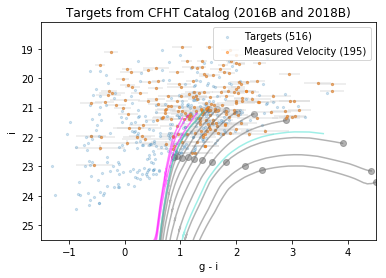

In [166]:
m = ((tbdata['ZQUALITY'] >= zqualityflag) & (~np.isnan(tbdata['G_AUTO_CFHT'])))
m2 = (~np.isnan(tbdata['G_AUTO_CFHT']))


for z in zini_array:
    # 10 Gyr, a selection of metallicities spanning the full rante of the isochrones
    m_iso = ((megacam_isos['label'] == 3) & (megacam_isos['logAge'] == 10.0) & (megacam_isos['Zini'] == z))
    plt.plot(megacam_isos['gmag'][m_iso] - megacam_isos['imag'][m_iso], 
             megacam_isos['imag'][m_iso]+m33_dmod, color='dimgrey', alpha=0.5, label = '_nolegend_')
    m_low = (megacam_isos[m_iso]['logL'] > lum_low_limit_cfht)
    plt.scatter(megacam_isos['gmag'][m_iso][m_low][0] - megacam_isos['imag'][m_iso][m_low][0], 
             megacam_isos['imag'][m_iso][m_low][0]+m33_dmod, color='dimgrey', alpha=0.5)
    plt.scatter(megacam_isos['gmag'][m_iso][-1] - megacam_isos['imag'][m_iso][-1], 
             megacam_isos['imag'][m_iso][-1]+m33_dmod, color='dimgrey', alpha=0.5)


m_iso_r = ((megacam_isos['label'] == 3) & (megacam_isos['logAge'] == 10.0) & (megacam_isos['Zini'] == zini_red_cfht))
m_iso_p = ((megacam_isos['label'] == 3) & (megacam_isos['logAge'] == 10.0) & (megacam_isos['Zini'] == zini_blue))
plt.plot(megacam_isos['gmag'][m_iso_r] - megacam_isos['imag'][m_iso_r], 
            megacam_isos['imag'][m_iso_r]+m33_dmod, color='turquoise', alpha=0.5, label = '_nolegend_')
plt.plot(megacam_isos['gmag'][m_iso_p] - megacam_isos['imag'][m_iso_p], 
            megacam_isos['imag'][m_iso_p]+m33_dmod, color='turquoise', alpha=0.5, label = '_nolegend_')


for z in zini_array[0:3]:
    # 2 Gyr, 3 most metal-poor
    m_iso = ((megacam_isos['label'] == 3) & (megacam_isos['logAge'] == 9.301) & (megacam_isos['Zini'] == z))
    plt.plot(megacam_isos['gmag'][m_iso] - megacam_isos['imag'][m_iso], 
             megacam_isos['imag'][m_iso]+m33_dmod, color='magenta', alpha=0.5, label = '_nolegend_')
    

clrerr = np.sqrt(tbdata['G_AUTO_CFHT_ERR']**2. + tbdata['I_AUTO_CFHT_ERR']*2.)
plt.errorbar(tbdata['G_AUTO_CFHT_0'][m] - tbdata['I_AUTO_CFHT_0'][m], tbdata['I_AUTO_CFHT_0'][m], 
             xerr = clrerr[m], yerr = tbdata['I_AUTO_CFHT_ERR'][m], alpha=0.5, fmt = 'none',
             color = 'lightgrey', label = '_nolegend_', zorder = 1)
plt.scatter(tbdata['G_AUTO_CFHT_0'] - tbdata['I_AUTO_CFHT_0'], tbdata['I_AUTO_CFHT_0'], s=5, alpha=0.2,
            label = 'Targets ('+str(len(tbdata['G_AUTO_CFHT'][m2]))+')')
plt.scatter(tbdata['G_AUTO_CFHT_0'][m] - tbdata['I_AUTO_CFHT_0'][m], tbdata['I_AUTO_CFHT_0'][m], s=5, alpha=0.5,
            label = 'Measured Velocity ('+str(len(tbdata['G_AUTO_CFHT'][m]))+')')

plt.xlim(-1.5,4.5)
plt.ylim(25.5,18.1)
plt.legend()
plt.xlabel('g - i')
plt.ylabel('i')
plt.title('Targets from CFHT Catalog (2016B and 2018B)')

Text(0.5, 1.0, 'Targets from 2016B HST Catalogs')

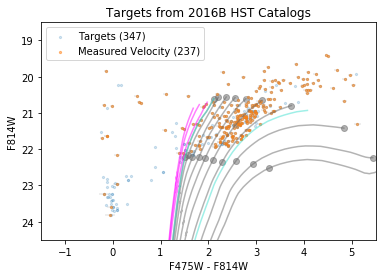

In [167]:
m = ((tbdata['ZQUALITY'] >= zqualityflag) & (~np.isnan(tbdata['F475W_ACS'])))
m2 = (~np.isnan(tbdata['F475W_ACS']))

#plt.scatter(tbdata['F475W_ACS']-tbdata['F814W_ACS'], tbdata['F814W_ACS'], s=5, alpha=0.2,
#            label = 'Targets ('+str(len(tbdata['F475W_ACS'][m2]))+')')
#plt.scatter(tbdata['F475W_ACS'][m]-tbdata['F814W_ACS'][m], tbdata['F814W_ACS'][m], s=5, alpha=0.5,
#            label = 'Measured Velocity ('+str(len(tbdata['F814W_ACS'][m]))+')')



for z in zini_array:
    # 10 Gyr, a selection of metallicities spanning the full rante of the isochrones
    m_iso = ((hstacs_isos['label'] == 3) & (hstacs_isos['logAge'] == 10.0) & (hstacs_isos['Zini'] == z))
    plt.plot(hstacs_isos['F475Wmag'][m_iso] - hstacs_isos['F814Wmag'][m_iso], 
             hstacs_isos['F814Wmag'][m_iso]+m33_dmod, color='dimgrey', alpha=0.5, label = '_nolegend_')
    m_low = (hstacs_isos[m_iso]['logL'] > lum_low_limit_f475w_16b)
    plt.scatter(hstacs_isos['F475Wmag'][m_iso][m_low][0] - hstacs_isos['F814Wmag'][m_iso][m_low][0], 
             hstacs_isos['F814Wmag'][m_iso][m_low][0]+m33_dmod, color='dimgrey', alpha=0.5)
    plt.scatter(hstacs_isos['F475Wmag'][m_iso][-1] - hstacs_isos['F814Wmag'][m_iso][-1], 
             hstacs_isos['F814Wmag'][m_iso][-1]+m33_dmod, color='dimgrey', alpha=0.5)

m_iso_r = ((hstacs_isos['label'] == 3) & (hstacs_isos['logAge'] == 10.0) & (hstacs_isos['Zini'] == zini_red_f475w_16b))
m_iso_p = ((hstacs_isos['label'] == 3) & (hstacs_isos['logAge'] == 10.0) & (hstacs_isos['Zini'] == zini_blue))
plt.plot(hstacs_isos['F475Wmag'][m_iso_r] - hstacs_isos['F814Wmag'][m_iso_r], 
            hstacs_isos['F814Wmag'][m_iso_r]+m33_dmod, color='turquoise', alpha=0.5, label = '_nolegend_')
plt.plot(hstacs_isos['F475Wmag'][m_iso_p] - hstacs_isos['F814Wmag'][m_iso_p], 
            hstacs_isos['F814Wmag'][m_iso_p]+m33_dmod, color='turquoise', alpha=0.5, label = '_nolegend_')

for z in zini_array[0:3]:
    # 2 Gyr, 3 most metal-poor
    m_iso = ((hstacs_isos['label'] == 3) & (hstacs_isos['logAge'] == 9.301) & (hstacs_isos['Zini'] == z))
    plt.plot(hstacs_isos['F475Wmag'][m_iso] - hstacs_isos['F814Wmag'][m_iso], 
             hstacs_isos['F814Wmag'][m_iso]+m33_dmod, color='magenta', alpha=0.5, label = '_nolegend_')

clrerr = np.sqrt(tbdata['F475W_ACS_ERR']**2. + tbdata['F814W_ACS_ERR']*2.)
plt.errorbar(tbdata['F475W_ACS_0'][m] - tbdata['F814W_ACS_0'][m], tbdata['F814W_ACS_0'][m], 
             xerr = clrerr[m], yerr = tbdata['F814W_ACS_ERR'][m], alpha=0.5, fmt = 'none',
             color = 'lightgrey', label = '_nolegend_', zorder = 1)
plt.scatter(tbdata['F475W_ACS_0']-tbdata['F814W_ACS_0'], tbdata['F814W_ACS_0'], s=5, alpha=0.2,
            label = 'Targets ('+str(len(tbdata['F475W_ACS'][m2]))+')')
plt.scatter(tbdata['F475W_ACS_0'][m]-tbdata['F814W_ACS_0'][m], tbdata['F814W_ACS_0'][m], s=5, alpha=0.5,
            label = 'Measured Velocity ('+str(len(tbdata['F814W_ACS'][m]))+')')
plt.xlim(-1.5,5.5)
plt.ylim(24.5,18.5)
plt.legend()
plt.xlabel('F475W - F814W')
plt.ylabel('F814W')
plt.title('Targets from 2016B HST Catalogs')

Text(0.5, 1.0, 'Targets from 2016B HST Catalogs')

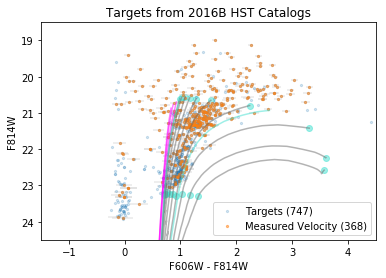

In [168]:
m = ((tbdata['ZQUALITY'] >= zqualityflag) & (~np.isnan(tbdata['F606W_ACS'])))
m2 = (~np.isnan(tbdata['F606W_ACS']))

#plt.scatter(tbdata['F606W_ACS']-tbdata['F814W_ACS'], tbdata['F814W_ACS'], s=5, alpha=0.2, 
#            label = 'Targets ('+str(len(tbdata['F606W_ACS'][m2]))+')')
#plt.scatter(tbdata['F606W_ACS'][m]-tbdata['F814W_ACS'][m], tbdata['F814W_ACS'][m], s=5, alpha=0.5, 
#            label = 'Measured Velocity ('+str(len(tbdata['F606W_ACS'][m]))+')')



for z in zini_array:
    # 10 Gyr, a selection of metallicities spanning the full rante of the isochrones
    m_iso = ((hstacs_isos['label'] == 3) & (hstacs_isos['logAge'] == 10.0) & (hstacs_isos['Zini'] == z))
    plt.plot(hstacs_isos['F606Wmag'][m_iso] - hstacs_isos['F814Wmag'][m_iso], 
             hstacs_isos['F814Wmag'][m_iso]+m33_dmod, color='dimgrey', alpha=0.5, label = '_nolegend_')
    m_low = (hstacs_isos[m_iso]['logL'] > lum_low_limit_f606w)
    plt.scatter(hstacs_isos['F606Wmag'][m_iso][m_low][0] - hstacs_isos['F814Wmag'][m_iso][m_low][0], 
             hstacs_isos['F814Wmag'][m_iso][m_low][0]+m33_dmod, color='turquoise', alpha=0.5)
    plt.scatter(hstacs_isos['F606Wmag'][m_iso][-1] - hstacs_isos['F814Wmag'][m_iso][-1], 
             hstacs_isos['F814Wmag'][m_iso][-1]+m33_dmod, color='turquoise', alpha=0.5)

m_iso_r = ((hstacs_isos['label'] == 3) & (hstacs_isos['logAge'] == 10.0) & (hstacs_isos['Zini'] == zini_red_f606w))
m_iso_p = ((hstacs_isos['label'] == 3) & (hstacs_isos['logAge'] == 10.0) & (hstacs_isos['Zini'] == zini_blue))
plt.plot(hstacs_isos['F606Wmag'][m_iso_r] - hstacs_isos['F814Wmag'][m_iso_r], 
            hstacs_isos['F814Wmag'][m_iso_r]+m33_dmod, color='turquoise', alpha=0.5, label = '_nolegend_')
plt.plot(hstacs_isos['F606Wmag'][m_iso_p] - hstacs_isos['F814Wmag'][m_iso_p], 
            hstacs_isos['F814Wmag'][m_iso_p]+m33_dmod, color='turquoise', alpha=0.5, label = '_nolegend_')


for z in zini_array[0:3]:
    # 2 Gyr, 3 most metal-poor
    m_iso = ((hstacs_isos['label'] == 3) & (hstacs_isos['logAge'] == 9.301) & (hstacs_isos['Zini'] == z))
    plt.plot(hstacs_isos['F606Wmag'][m_iso] - hstacs_isos['F814Wmag'][m_iso], 
             hstacs_isos['F814Wmag'][m_iso]+m33_dmod, color='magenta', alpha=0.5, label = '_nolegend_')


clrerr = np.sqrt(tbdata['F606W_ACS_ERR']**2. + tbdata['F814W_ACS_ERR']*2.)
plt.errorbar(tbdata['F606W_ACS_0'][m] - tbdata['F814W_ACS_0'][m], tbdata['F814W_ACS_0'][m], 
             xerr = clrerr[m], yerr = tbdata['F814W_ACS_ERR'][m], alpha=0.5, fmt = 'none',
             color = 'lightgrey', label = '_nolegend_', zorder = 1)
plt.scatter(tbdata['F606W_ACS_0']-tbdata['F814W_ACS_0'], tbdata['F814W_ACS_0'], s=5, alpha=0.2, 
            label = 'Targets ('+str(len(tbdata['F606W_ACS'][m2]))+')')
plt.scatter(tbdata['F606W_ACS_0'][m]-tbdata['F814W_ACS_0'][m], tbdata['F814W_ACS_0'][m], s=5, alpha=0.5, 
            label = 'Measured Velocity ('+str(len(tbdata['F606W_ACS'][m]))+')')
plt.xlim(-1.5,4.5)
plt.ylim(24.5,18.5)
plt.legend()
plt.xlabel('F606W - F814W')
plt.ylabel('F814W')
plt.title('Targets from 2016B HST Catalogs')

Text(0.5, 1.0, 'Targets from 2018B HST Catalogs')

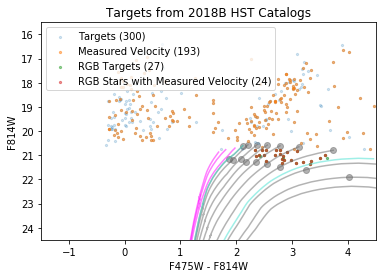

In [169]:
m = ((tbdata['ZQUALITY'] >= zqualityflag) & (~np.isnan(tbdata['F475W_VEGA'])))
m2 = (~np.isnan(tbdata['F475W_VEGA']))


for z in zini_array:
    # 10 Gyr, a selection of metallicities spanning the full rante of the isochrones
    m_iso = ((hstacs_isos['label'] == 3) & (hstacs_isos['logAge'] == 10.0) & (hstacs_isos['Zini'] == z))
    plt.plot(hstacs_isos['F475Wmag'][m_iso] - hstacs_isos['F814Wmag'][m_iso], 
             hstacs_isos['F814Wmag'][m_iso]+m33_dmod, color='dimgrey', alpha=0.5, label = '_nolegend_')
    m_low = (hstacs_isos[m_iso]['logL'] > lum_low_limit_f475w_18b)
    plt.scatter(hstacs_isos['F475Wmag'][m_iso][m_low][0] - hstacs_isos['F814Wmag'][m_iso][m_low][0], 
             hstacs_isos['F814Wmag'][m_iso][m_low][0]+m33_dmod, color='dimgrey', alpha=0.5)
    plt.scatter(hstacs_isos['F475Wmag'][m_iso][-1] - hstacs_isos['F814Wmag'][m_iso][-1], 
             hstacs_isos['F814Wmag'][m_iso][-1]+m33_dmod, color='dimgrey', alpha=0.5)

m_iso_r = ((hstacs_isos['label'] == 3) & (hstacs_isos['logAge'] == 10.0) & (hstacs_isos['Zini'] == zini_red_f475w_18b))
m_iso_p = ((hstacs_isos['label'] == 3) & (hstacs_isos['logAge'] == 10.0) & (hstacs_isos['Zini'] == zini_blue))
plt.plot(hstacs_isos['F475Wmag'][m_iso_r] - hstacs_isos['F814Wmag'][m_iso_r], 
            hstacs_isos['F814Wmag'][m_iso_r]+m33_dmod, color='turquoise', alpha=0.5, label = '_nolegend_')
plt.plot(hstacs_isos['F475Wmag'][m_iso_p] - hstacs_isos['F814Wmag'][m_iso_p], 
            hstacs_isos['F814Wmag'][m_iso_p]+m33_dmod, color='turquoise', alpha=0.5, label = '_nolegend_')


for z in zini_array[0:3]:
    # 2 Gyr, 3 most metal-poor
    m_iso = ((hstacs_isos['label'] == 3) & (hstacs_isos['logAge'] == 9.301) & (hstacs_isos['Zini'] == z))
    plt.plot(hstacs_isos['F475Wmag'][m_iso] - hstacs_isos['F814Wmag'][m_iso], 
             hstacs_isos['F814Wmag'][m_iso]+m33_dmod, color='magenta', alpha=0.5, label = '_nolegend_')


plt.scatter(tbdata['F475W_VEGA_0']-tbdata['F814W_VEGA_0'], tbdata['F814W_VEGA_0'], s=5, alpha=0.2, 
            label = 'Targets ('+str(len(tbdata['F475W_VEGA'][m2]))+')')
plt.scatter(tbdata['F475W_VEGA_0'][m]-tbdata['F814W_VEGA_0'][m], tbdata['F814W_VEGA_0'][m], s=5, alpha=0.5, 
            label = 'Measured Velocity ('+str(len(tbdata['F475W_VEGA'][m]))+')')
#plt.scatter(tbdata['F475W_VEGA_0'][m]-tbdata['F814W_VEGA_0'][m], tbdata['F814W_VEGA_0'][m], s=5, alpha=0.5, 
#            label = 'Measured Velocity (extinction corrected)')
m3 = ((np.core.defchararray.find(list(tbdata['TARGTYPE']),'RGB') > -1) & (~np.isnan(tbdata['F475W_VEGA'])))
plt.scatter(tbdata['F475W_VEGA_0'][m3]-tbdata['F814W_VEGA_0'][m3], tbdata['F814W_VEGA_0'][m3], s=5, alpha=0.5, 
            label = 'RGB Targets ('+str(len(tbdata['F475W_VEGA'][m3]))+')')
m3 = ((np.core.defchararray.find(list(tbdata['TARGTYPE']),'RGB') > -1) & (~np.isnan(tbdata['F475W_VEGA'])) 
      & (tbdata['ZQUALITY'] >= zqualityflag))
plt.scatter(tbdata['F475W_VEGA_0'][m3]-tbdata['F814W_VEGA_0'][m3], tbdata['F814W_VEGA_0'][m3], s=5, alpha=0.5, 
            label = 'RGB Stars with Measured Velocity ('+str(len(tbdata['F475W_VEGA'][m3]))+')')
plt.xlim(-1.5,4.5)
plt.ylim(24.5,15.5)
plt.legend()
plt.xlabel('F475W - F814W')
plt.ylabel('F814W')
plt.title('Targets from 2018B HST Catalogs')

In [170]:
# create a polygon from the isochrones
def isochrone_poly(bluefilt, redfilt, zini_blue, zini_red, lum_low_limit, isochrones, age = 10.0, dmod = m33_dmod):
    poly = []

    # simplify logic statements below
    m_iso_init = ((isochrones['label'] == 3) & (isochrones['logAge'] == age))
    isochrones = isochrones[m_iso_init]
    
    # first, the metal-poor isochrone
    m_iso = ((isochrones['logL'] > lum_low_limit) & (isochrones['Zini'] == zini_blue))
    for p in isochrones[m_iso]:
        poly.append([p[bluefilt] - p[redfilt], p[redfilt]+dmod])

    # next, the TRGB up to the metal-rich isochrone you want to stop at
    for z in list(sorted(set(megacam_isos['Zini']))):
        #print(z)
        if z > zini_blue and z < zini_red:
            m_iso = (isochrones['Zini'] == z)
            poly.append([isochrones[bluefilt][m_iso][-1] - isochrones[redfilt][m_iso][-1],
                         isochrones[redfilt][m_iso][-1]+dmod])

    # next, the metal-rich isochrone, in revere order though
    m_iso = ((isochrones['logL'] > lum_low_limit) & (isochrones['Zini'] == zini_red))
    for p in isochrones[m_iso][::-1]: # this reverses the order of the isochrone
        poly.append([p[bluefilt] - p[redfilt], p[redfilt]+dmod])

    for z in list(sorted(set(isochrones['Zini'])))[::-1]:
        if z > zini_blue and z < zini_red:
            m_iso = ((isochrones['Zini'] == z) & (isochrones['logL'] > lum_low_limit))
            poly.append([isochrones[bluefilt][m_iso][0] - isochrones[redfilt][m_iso][0],
                  isochrones[redfilt][m_iso][0]+dmod])
    return(poly)
#print(poly)
#print([a[0] for a in poly])

def plt_isochrone_poly(poly, xlim=[-1.5,4.5], ylim = [24.5,18.5]):
    plt.plot([a[0] for a in poly], [a[1] for a in poly], lw = 2)
    plt.scatter([a[0] for a in poly], [a[1] for a in poly], s = 10, alpha=0.5, color='magenta')
    plt.xlim(xlim[0], xlim[1])
    plt.ylim(ylim[0], ylim[1])
    plt.show()
    
    return

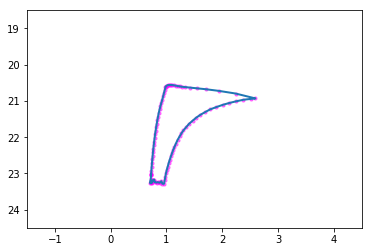

In [171]:
bluefilt = 'F606Wmag'
redfilt = 'F814Wmag'
zini_red = zini_red_f606w
lum_low_limit = lum_low_limit_f606w
isochrones = hstacs_isos

poly_f606w = isochrone_poly(bluefilt, redfilt, zini_blue, zini_red, lum_low_limit, isochrones)
plt_isochrone_poly(poly_f606w)

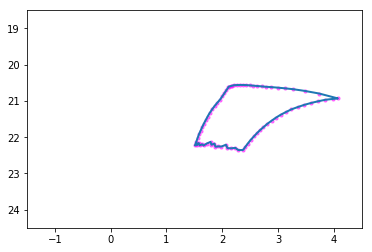

In [172]:
bluefilt = 'F475Wmag'
redfilt = 'F814Wmag'
zini_red = zini_red_f475w_16b
lum_low_limit = lum_low_limit_f475w_16b
isochrones = hstacs_isos

poly_f475w_16b = isochrone_poly(bluefilt, redfilt, zini_blue, zini_red, lum_low_limit, isochrones)
plt_isochrone_poly(poly_f475w_16b)

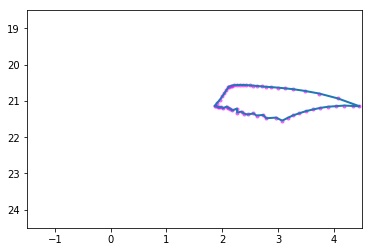

In [173]:
bluefilt = 'F475Wmag'
redfilt = 'F814Wmag'
zini_red = zini_red_f475w_18b
lum_low_limit = lum_low_limit_f475w_18b
isochrones = hstacs_isos

poly_f475w_18b = isochrone_poly(bluefilt, redfilt, zini_blue, zini_red, lum_low_limit, isochrones)
plt_isochrone_poly(poly_f475w_18b)

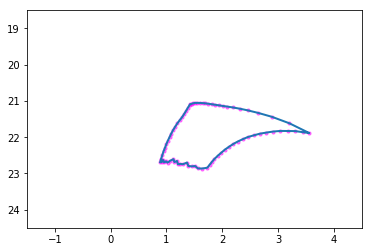

In [174]:
bluefilt = 'gmag'
redfilt = 'imag'
zini_red = zini_red_cfht
lum_low_limit = lum_low_limit_cfht
isochrones = megacam_isos

poly_cfht = isochrone_poly(bluefilt, redfilt, zini_blue, zini_red, lum_low_limit, isochrones)
plt_isochrone_poly(poly_cfht)

In [175]:
from matplotlib import path


(24.5, 15.5)

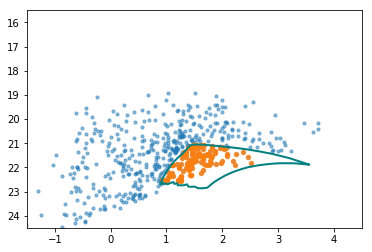

In [176]:
p = path.Path(poly_cfht)

color = tbdata['G_AUTO_CFHT_0'] - tbdata['I_AUTO_CFHT_0']
mag = tbdata['I_AUTO_CFHT_0']
points = []
for c,m in zip(color, mag):
    points.append([c,m])
#print(points[0:2])
m_sel_cfht = p.contains_points(points)
#print(color[m])

plt.plot([a[0] for a in poly_cfht], [a[1] for a in poly_cfht], lw = 2, color='teal')
plt.scatter(color,mag, s=10, alpha=0.5)
plt.scatter(color[m_sel_cfht],mag[m_sel_cfht], s=20, alpha=0.75)
plt.xlim(-1.5,4.5)
plt.ylim(24.5,15.5)

(24.5, 15.5)

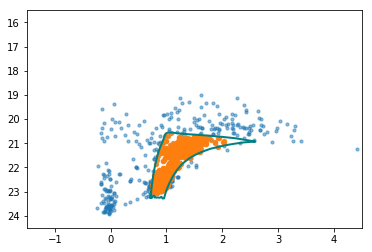

In [177]:
p = path.Path(poly_f606w)

color = tbdata['F606W_ACS_0'] - tbdata['F814W_ACS_0']
mag = tbdata['F814W_ACS_0']
points = []
for c,m in zip(color, mag):
    points.append([c,m])
#print(points[0:2])
m_sel_f606w = p.contains_points(points)
#print(color[m])

plt.plot([a[0] for a in poly_f606w], [a[1] for a in poly_f606w], lw = 2, color='teal')
plt.scatter(color,mag, s=10, alpha=0.5)
plt.scatter(color[m_sel_f606w],mag[m_sel_f606w], s=20, alpha=0.75)
plt.xlim(-1.5,4.5)
plt.ylim(24.5,15.5)

(24.5, 15.5)

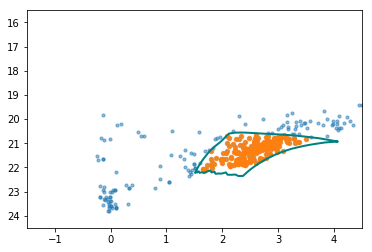

In [178]:
p = path.Path(poly_f475w_16b)

color = tbdata['F475W_ACS_0'] - tbdata['F814W_ACS_0']
mag = tbdata['F814W_ACS_0']
points = []
for c,m in zip(color, mag):
    points.append([c,m])
#print(points[0:2])
m_sel_f475w_16b = p.contains_points(points)
#print(color[m])

plt.plot([a[0] for a in poly_f475w_16b], [a[1] for a in poly_f475w_16b], lw = 2, color='teal')
plt.scatter(color,mag, s=10, alpha=0.5)
plt.scatter(color[m_sel_f475w_16b],mag[m_sel_f475w_16b], s=20, alpha=0.75)
plt.xlim(-1.5,4.5)
plt.ylim(24.5,15.5)

(24.5, 15.5)

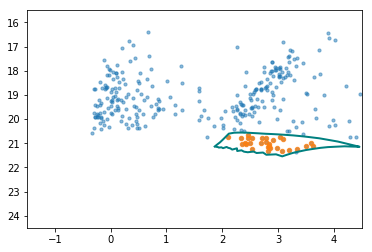

In [179]:
p = path.Path(poly_f475w_18b)

color = tbdata['F475W_VEGA_0'] - tbdata['F814W_VEGA_0']
mag = tbdata['F814W_VEGA_0']
points = []
for c,m in zip(color, mag):
    points.append([c,m])
#print(points[0:2])
m_sel_f475w_18b = p.contains_points(points)
#print(color[m])

plt.plot([a[0] for a in poly_f475w_18b], [a[1] for a in poly_f475w_18b], lw = 2, color='teal')
plt.scatter(color,mag, s=10, alpha=0.5)
plt.scatter(color[m_sel_f475w_18b],mag[m_sel_f475w_18b], s=20, alpha=0.75)
plt.xlim(-1.5,4.5)
plt.ylim(24.5,15.5)

In [180]:
# add an RGB selection column to tbdata
selected = Column(Column(np.ones(len(tbdata))*np.nan, name='RGB_SELECTION'))
tbdata.add_columns([selected])

In [181]:
tbdata['RGB_SELECTION'][m_sel_cfht] = 1
tbdata['RGB_SELECTION'][m_sel_f606w] = 1
tbdata['RGB_SELECTION'][m_sel_f475w_16b] = 1
tbdata['RGB_SELECTION'][m_sel_f475w_18b] = 1
#print(tbdata['RGB_SELECTION'])

## Prep a Data Table for Velocity Analysis

I want to keep all stars with zquality 3 or 4, and in the selection boxes.  

I also want to remove duplicate velocity measurements, replacing them with one line, the velocity being the weighted average of the velocities.  And to use these repeat measurements to estimate the systematic velocity error.

**Note: the following is not foolproof- once have more 18b masks, could have false objname overlap between 16B CFHT and HST targets.  But with initial complement of masks it works without fancier logic, so moving on.**

In [182]:
m_velfit = ((tbdata['ZQUALITY'] >= zqualityflag) & (tbdata['RGB_SELECTION'] == 1))
print(len(tbdata[m_velfit]))

442


In [183]:
velfit_tbdata = tbdata[m_velfit]

In [184]:
dup = Column(Column(np.zeros(len(velfit_tbdata)), name='DUPLICATE'))
velfit_tbdata.add_columns([dup])

In [185]:
# a very simple statement to figure out the scope of the problem
duplicates = set([x for x in list(velfit_tbdata['OBJNAME']) if list(velfit_tbdata['OBJNAME']).count(x) > 1])

In [186]:
# what I really want are indices however
duplicates = [i for i, x in enumerate(list(velfit_tbdata['OBJNAME'])) if list(velfit_tbdata['OBJNAME']).count(x) > 1]
print(duplicates)
#print(velfit_tbdata['OBJNAME'][duplicates])

not_duplicates = [i for i, x in enumerate(list(velfit_tbdata['OBJNAME'])) if list(velfit_tbdata['OBJNAME']).count(x) == 1]
#print(not_duplicates)

#print(len(velfit_tbdata['OBJNAME'][not_duplicates]))
#print(len(velfit_tbdata['OBJNAME'][duplicates]))
#print(len(velfit_tbdata['OBJNAME']))

[23, 39, 42, 45, 46, 57, 60, 63, 64, 65, 66, 67, 70, 71, 206, 266]


There are currently only 8, which is only 2% of the sample.  

In [187]:
velfit_tbdata_dups = velfit_tbdata[duplicates]
velfit_tbdata_nodups = velfit_tbdata[not_duplicates]
print(len(velfit_tbdata_dups), len(velfit_tbdata_nodups), len(velfit_tbdata))

16 426 442


In [188]:
def duplicate_velocities(datatable, keyval = 'OBJNAME', velflag = 40.):
    # datatable: an astropy Table of data full of duplicate entries
    # keyval: the Column on which to match
    
    for i,o in enumerate(list(datatable[keyval])):
        # is o still in datatable[keyval] twice?
        if list(datatable[keyval]).count(o) > 1:
            #print(o,' is still in list twice: ',list(datatable[keyval]).count(o))
            # identify indices
            mi = [i for i,x in enumerate(list(datatable['OBJNAME'])) if x == o]
            #print(datatable[keyval][mi], datatable['RA'][mi], datatable['DEC'][mi])
            if len(datatable['VCORR'][mi]) !=2:
                print('There are more than 2 matches for this object: ', o)
            elif datatable['RA'][mi[0]] != datatable['RA'][mi[1]]:
                print('Possible mismatch: ', datatable[keyval][mi], datatable['RA'][mi], datatable['DEC'][mi])
            else:
                print(datatable['VCORR'][mi], datatable['VERR'][mi], datatable['SN'][mi], datatable['ZQUALITY'][mi]) 
                weight_vel_sum, weight_snr_sum, weight = 0.0, 0.0, 0.0
                for v,s,e in zip(datatable['VCORR'][mi], datatable['SN'][mi], datatable['VERR'][mi]):
                    weight_vel_sum += v/e**2.
                    weight_snr_sum += s/e**2.
                    weight += e**-2.
                print('weighted mean velocity: ', weight_vel_sum/weight)
                print('weighted SNR: ', weight_snr_sum/weight)
                print('standard error of weighted mean: ', np.sqrt(1./weight))
                if (abs(datatable['VCORR'][mi[0]] - datatable['VCORR'][mi[1]]) >= velflag) \
                    and (datatable['ZQUALITY'][mi[0]] - datatable['ZQUALITY'][mi[1]] > 0):
                    print('Large Discrepancy in VCORR, and differing zquality.  Taking row with zquality = 4')
                    if datatable['ZQUALITY'][mi[0]] == 4:
                        datatable['DUPLICATE'][mi[0]] = 1
                        datatable['DUPLICATE'][mi[1]] = -999
                    else:
                        datatable['DUPLICATE'][mi[0]] = -999
                        datatable['DUPLICATE'][mi[1]] = 1
                else:
                    datatable['VCORR'][mi[0]] = weight_vel_sum/weight
                    datatable['VERR'][mi[0]] = np.sqrt(1./weight)
                    datatable['SN'][mi[0]] = weight_snr_sum/weight
                    datatable['DUPLICATE'][mi[0]] = 1
                    datatable['DUPLICATE'][mi[1]] = -999
                #newmask = datatable['MASKNAME'][mi[0]]+';'+datatable['MASKNAME'][mi[1]]
                #print('new maskname: ', newmask)
                #row['MASKNAME'] = newmask
                    
            #if i == 0:
            #    datatable_unique = row
            #else:
            #    datatable_unique = vstack((datatable_unique,row))
                     
    return

In [189]:
duplicate_velocities(velfit_tbdata_dups)

    VCORR     
    km / s    
--------------
-123.281794418
-119.347526163   VERR 
 km / s
-------
13.3244
3.61406    SN  
-------
8.14158
8.06941 ZQUALITY
--------
       4
       4
weighted mean velocity:  -119.617132264
weighted SNR:  8.07435884224
standard error of weighted mean:  3.48803583615
    VCORR     
    km / s    
--------------
-122.189525059
-98.9745602946   VERR 
 km / s
-------
2.45092
2.72428    SN  
-------
21.3772
18.3031 ZQUALITY
--------
       4
       4
weighted mean velocity:  -111.804895082
weighted SNR:  20.0020747524
standard error of weighted mean:  1.82206293595
    VCORR     
    km / s    
--------------
 -139.31414977
-173.244467681    VERR  
  km / s 
---------
-299792.0
  13.4806    SN  
-------
5.22721
5.80943 ZQUALITY
--------
       4
       4
weighted mean velocity:  -173.244467613
weighted SNR:  5.80942964436
standard error of weighted mean:  13.4805621965
    VCORR     
    km / s    
--------------
-151.080785138
-145.127293978   VERR 
 km / s

In [198]:
print(velfit_tbdata_dups['DUPLICATE'])

DUPLICATE
---------
      1.0
      1.0
      1.0
      1.0
      1.0
      1.0
      1.0
   -999.0
   -999.0
   -999.0
   -999.0
   -999.0
   -999.0
   -999.0
      1.0
   -999.0


In [199]:
print(velfit_tbdata_dups['SN'])

   SN  
-------
8.07197
 19.477
5.80943
16.1287
33.3867
3.18855
7.90075
8.06941
18.3031
5.80943
 17.124
35.7834
3.89833
8.24303
18.1619
13.2205


In [200]:
velfit_tbdata_use = vstack((velfit_tbdata_nodups, velfit_tbdata_dups))

In [201]:
print(len(velfit_tbdata_use))
print(len(velfit_tbdata_nodups))
print(len(velfit_tbdata_dups))

442
426
16


In [202]:
m = (velfit_tbdata_use['DUPLICATE'] >= 0)
#print(velfit_tbdata_use['DUPLICATE'][m])

Text(0, 0.5, 'Dec')

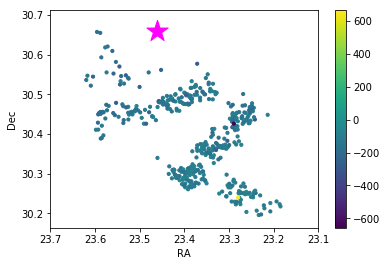

In [203]:
sc = SkyCoord(ra=velfit_tbdata_use['RA'], dec=velfit_tbdata_use['DEC'], unit=(u.hourangle, u.deg))

colorvals = velfit_tbdata_use['VCORR'][m]
cmap_choice = 'viridis'

vc = plt.scatter(sc[m].ra.deg, sc[m].dec.deg, c=colorvals, s=10)
plt.scatter(m33coord.ra.deg, m33coord.dec.deg, s=500, marker="*", c='fuchsia')

cbar = plt.colorbar(vc)
cbar.ax.set_ylabel('Velocity (km s$^{-1}$)')
cbar.set_alpha(1)
cbar.draw_all()

plt.xlim(23.7,23.1)
plt.xlabel('RA')
plt.ylabel('Dec')

In [204]:
print(velfit_tbdata_use)

CLASS       SUBCLASS      OBJNAME  ...    EBV_SFD98    RGB_SELECTION DUPLICATE
                                   ...                                        
------ ----------------- --------- ... --------------- ------------- ---------
STAR   HD061913 M2II-III 5003038   ...   0.04495218735           1.0       0.0
STAR   HD061913 M2II-III 181325    ... 0.0490290234572           1.0       0.0
STAR   HD52005 K4Iab     198740    ... 0.0489114984083           1.0       0.0
STAR   HD061913 M2II-III 212176    ... 0.0462441454975           1.0       0.0
STAR   HD061913 M2II-III 220006    ... 0.0457043538137           1.0       0.0
STAR   HD60522 M0III     226705    ... 0.0459817780838           1.0       0.0
STAR   HD151217 K5III    227559    ... 0.0455636522564           1.0       0.0
STAR   HD151217 K5III    229794    ... 0.0455396729282           1.0       0.0
STAR   HD197572 F7Ib     238675    ... 0.0454111446086           1.0       0.0
STAR   HD164349 K0.5IIb  11000985  ... 0.04346415364

In [206]:
filename = 'm33_velocitydata.fits'
velfit_tbdata_use.write(filename)
#velfit_tbdata_use.write(filename, overwrite = True)